## Airbnb Data Challenge 

Data taken from:

The dataset has data about rental places from Latin America's capital, Rio de Janeiro. One can propose the following challenges for the candidates:

- Estimate price variable for each observation. Regression Approach.
- Estimate room type variable for each observation. Classification Approach.

This notebook makes a superficial analysis of the dataset, paying attention on each requirement from the **Expectation** section on readme.md.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import math

from airbnb_prediction.config import data_dir_raw
from airbnb_prediction import preprocess, config

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv(data_dir_raw + '/listings_train.csv')

### 1. Basic Dataframe Info

We can check dataframe's shape to assert how many rows we have. The .head() method give us a glimpse of what we're about to attack.

In [3]:
df.shape

(13042, 74)

In [4]:
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,t,1,1,0,0,2.01
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\r\nI am a filmmaker and a tea...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$307.00,3,90,3.0,3.0,90.0,90.0,3.0,90.0,NaN,t,0,0,0,10,2021-02-23,85,0,0,2010-09-26,2018-02-14,95.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,0.67
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,Ghizlane,2012-10-03,"Rio de Janeiro, Rio de Janeiro, Brazil","French girl ""lost in Brazilian translation"" si...",within a few hours,97%,78%,f,https://a0.muscache.com/im/pictures/user/fffed...,https://a0.muscache.com/im/pictures/user/fffed...,Ipanema,11.0,11.0,"['phone', 'reviews', 'jumio', 'offline_governm...",t,f,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Elevator"", ""Dedicated workspace"", ""Kitche

### 2. Exploratory Data Analysis

Here we check on how data behaves. A good machine learning model heavily depends on how good we undestand our data and make use of them.

#### 2.1 Missing Data

Checking on how many missing data we have for each variable.

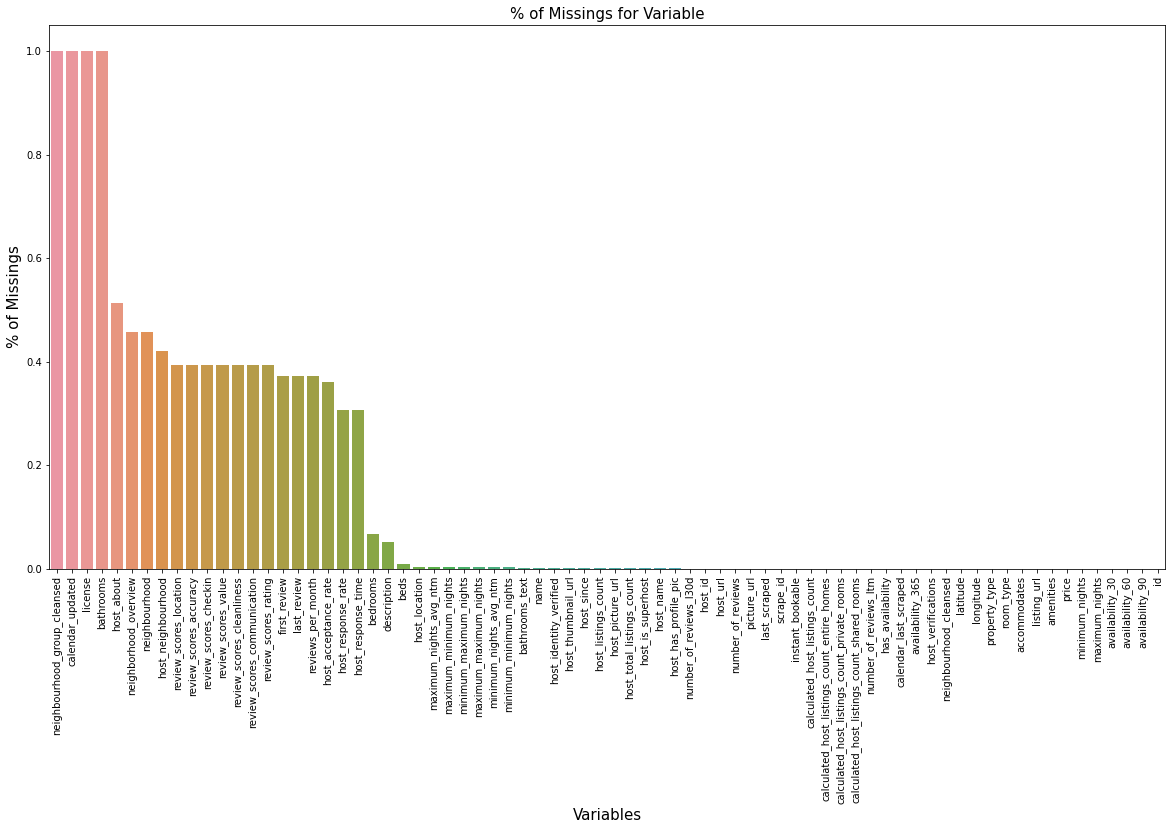

In [5]:
# Plotting Missing Values Info
preprocess.plot_missing_values(df)

As we can see, there are null columns in this dataset. For this very reason, they can be dropped without mercy. 

In [6]:
preprocess.dropping_empty_columns(df)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,t,1,1,0,0,2.01
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,"The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\r\nI am a filmmaker and a tea...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Ipanema,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$307.00,3,90,3.0,3.0,90.0,90.0,3.0,90.0,t,0,0,0,10,2021-02-23,85,0,0,2010-09-26,2018-02-14,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,1,1,0,0,0.67
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,Ghizlane,2012-10-03,"Rio de Janeiro, Rio de Janeiro, Brazil","French girl ""lost in Brazilian translation"" si...",within a few hours,97%,78%,f,https://a0.muscache.com/im/pictures/user/fffed...,https://a0.muscache.com/im/pictures/user/fffed...,Ipanema,11.0,11.0,"['phone', 'reviews', 'jumio', 'offline_governm...",t,f,"Rio de Janeiro, Brazil",Copacabana,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,1 bath,1.0,2.0,"[""Elevator"", ""Dedicated workspace"", ""Kitchen"",...",$160.00,7,60,7.0,7.0,60.0,60.0,7.0,60.0,t,0,23,53,328,2021-02-23,238,0,0,2010-06-07,2020-02-15,

#### 2.2 Target Variable: Price
Price comes as a string variable with special characters. Because of this, some cleaning must be done before any kind of exploration.

In [7]:
# Converting Price to Integer
df['price'] = df['price'].apply(lambda x: preprocess.convert_price_to_int(x))

As price has a heavily assimetric distribution by it's own nature, we shall work with it's log. It's not mandatory, however the log-transformation removes data asymmetry by shinking the data space and can be tested for normallity presumptions. The visualization below shows how the new variable behaves. 

In [8]:
df['log_price'] = np.log1p(df['price'])

The **log_price** changes the data scale. With less extreme values, both mean and std are significantly lower. The regression models can be used on log values and then, transformed back using the exponential function.

Mlflow can track both experiments, using either log and normal prices as target variables.

In [9]:
df['price'].describe()

count     13042.000000
mean        700.364285
std        3220.756224
min           0.000000
25%         159.000000
50%         280.500000
75%         554.000000
max      126233.000000
Name: price, dtype: float64

In [10]:
df['log_price'].describe()

count    13042.000000
mean         5.771984
std          1.005772
min          0.000000
25%          5.075174
50%          5.640131
75%          6.318968
max         11.745893
Name: log_price, dtype: float64

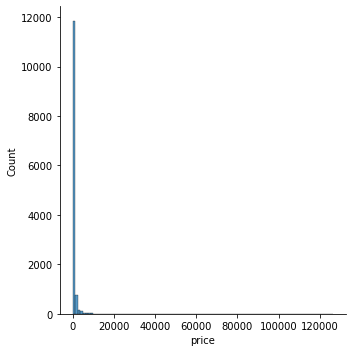

In [11]:
sns.displot((df['price']), bins=100)

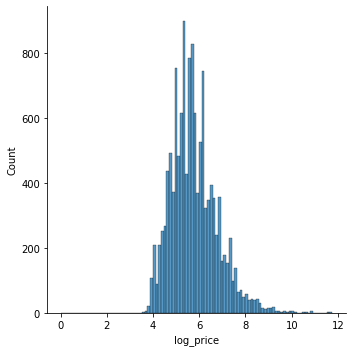

In [12]:
sns.displot(df['log_price'], bins=100)

<AxesSubplot:xlabel='price'>

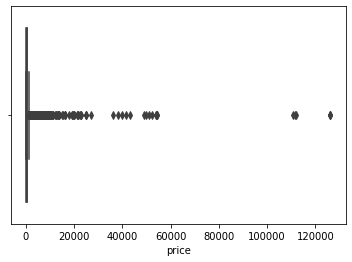

In [13]:
sns.boxplot(x=df['price'])

<AxesSubplot:xlabel='log_price'>

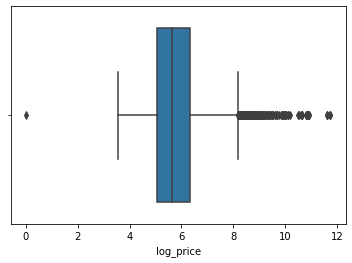

In [14]:
# A number of outliers are more explicit here.
sns.boxplot(x=df['log_price'])

#### 2.3 Feature Engineering

Using the present data, we can gather further insights and make new variables to help model's prediction. A number of new variables will be made accordingly.

##### 2.3.1 String Variables
String variables can say a number of things about our data. The most basic engineering that can be made on them are the number of characters each one has.

In [15]:
string_variables = [
    'name',
    'description',
    'neighborhood_overview',
    'host_about'   
]

In [16]:
# Create counting string variables from string_variables list and drop the former.
preprocess.count_characters_variables(df, string_variables)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,log_price,count_name,count_description,count_neighborhood_overview,count_host_about
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"VeryNice2BrinCopacabanaw.balcony,fastWiFi",Discountsforlongtermstays.<br/>-Largebalcony(2...,ThisistheoneofthebestsspotsinRio.Becauseofthel...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",Iamajournalist/writer.Livedfor15yearsinNYC.Iam...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",221,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,t,1,1,0,0,2.01,5.402677,41,835,121,144
1,24480,https://www.airbnb.com/rooms/24480,20210222161029,2021-02-23,NiceandcozynearIpanemaBeach,MystudioislocatedinthebestofIpanema.Twoblocksf...,"Thebeach,thelagoon,Ipanemaisagreatlocation,clo...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",WelcometoRio!\r\nIamafilmmakerandateacher.\r\n...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Ipanema,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",307,3,90,3.0,3.0,90.0,90.0,3.0,90.0,t,0,0,0,10,2021-02-23,85,0,0,2010-09-26,2018-02-14,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,1,1,0,0,0.67,5.730100,27,832,113,383
2,25026,https://www.airbnb.com/rooms/25026,20210222161029,2021-02-23,BeautifulModernDecoratedStudioinCopa,"Ourapartmentisalittlegem,everyonelovesstayingt...",Copacabanaisalivelyneighborhoodandtheapartment...,https://a0.muscache.com/pictures/3003965/68ebb...,3746246,https://www.airbnb.com/users/show/3746246,Ghizlane,2012-10-03,"Rio de Janeiro, Rio de Janeiro, Brazil","Frenchgirl""lostinBraziliantranslation""since201...",within a few hours,97%,78%,f,https://a0.muscache.com/im/pictures/user/fffed...,https://a0.muscache.com/im/pictures/user/fffed...,Ipanema,11.0,11.0,"['phone', 'reviews', 'jumio', 'offline_governm...",t,f,"Rio de Janeiro, Brazil",Copacabana,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,1 bath,1.0,2.0,"[""Elevator"", ""Dedicated workspace"", ""

In [17]:
for variable in string_variables:
    print(df['count_{}'.format(variable)].describe())

count    13042.000000
mean        31.394418
std         10.181540
min          0.000000
25%         25.000000
50%         31.000000
75%         39.000000
max        135.000000
Name: count_name, dtype: float64
count    13042.000000
mean       506.122604
std        283.018448
min          0.000000
25%        262.000000
50%        495.000000
75%        828.000000
max        891.000000
Name: count_description, dtype: float64
count    13042.000000
mean       130.036574
std        190.942733
min          0.000000
25%          0.000000
50%         43.000000
75%        194.750000
max        872.000000
Name: count_neighborhood_overview, dtype: float64
count    13042.000000
mean       159.325947
std        354.144484
min          0.000000
25%          0.000000
50%          0.000000
75%        178.000000
max       5658.000000
Name: count_host_about, dtype: float64


- **count_descripion** has a seemly uniform distribution, aside the max value that might be about the character limit.

- **count_name** has a rather exotic distribution (and almost a bimodal distribution). Most of it's data is within the 0-39 count range and some outliers (check the original variable to see these entries).

- Over 51% of the **host_about** variable is missing. People tend to speak less about themselves as it's distribution decreases as the length rises.

- The same happens similarly with **count_name**: Over 46% of it's data is missing and it has a descendent distribution.

Some hypothesis:

- Longer texts results in higher prices.
- If host describe themself or the host has a neighborhood overview (binary variable), the price is higher.

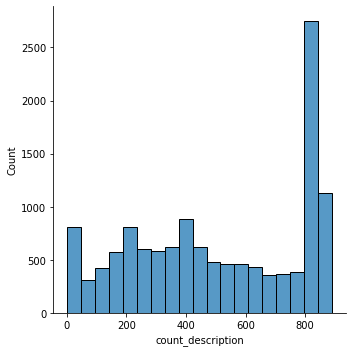

In [18]:
sns.displot(df['count_description'])

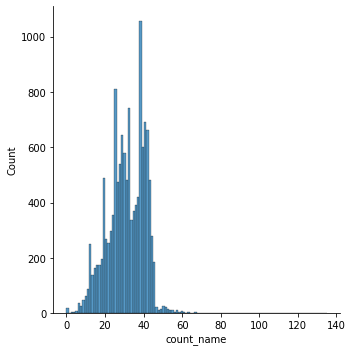

In [19]:
sns.displot(df['count_name'])

#### - Comparing Full X Filtered Variable: 'count_neighborhood_overview'

In [20]:
# Over 46% of the host_about variable is missing.
missing_host_about = df.query('count_neighborhood_overview==0').shape[0]
round(missing_host_about/df.shape[0], 3)

0.458

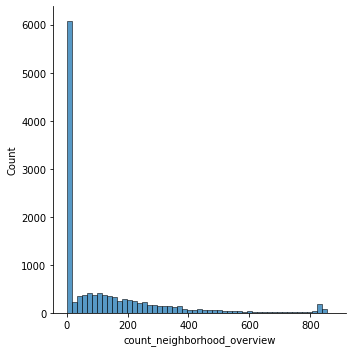

In [21]:
sns.displot(df['count_neighborhood_overview'])

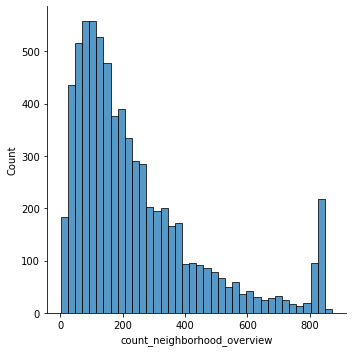

In [22]:
sns.displot(df[df['count_neighborhood_overview']>0]['count_neighborhood_overview'])

#### - Comparing Full X Filtered Variable: 'count_host_about'

In [23]:
# Over 51% of the host_about variable is missing.
missing_host_about = df.query('count_host_about==0').shape[0]
round(missing_host_about/df.shape[0], 3)

0.513

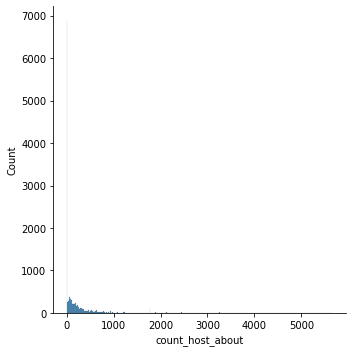

In [24]:
sns.displot(df['count_host_about'])

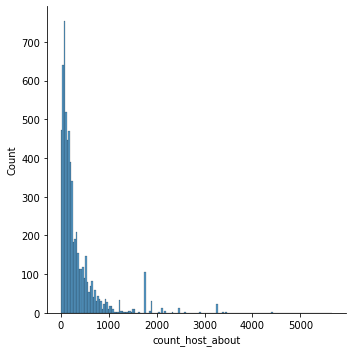

In [25]:
# Filtrando observações > 0
sns.displot(df[df['count_host_about']>0]['count_host_about'])

##### 2.3.2 Numerical Variables

Construction of some numerical variables

In [26]:
# Time Since Registered as Host
# Still, we have 24 missing values for this variable. 
# Check if its a new host crossing with review number and other variables.
df['days_since_host'] = (pd.to_datetime('today')-pd.to_datetime(df['host_since'])).dt.days

Bathrooms is a string variable, instead of a int. Because of that, we can make some manipulation like the **price** variable.

Definition for Half-Bath:
- a bathroom in a private home that contains a toilet and sink but no bathtub or shower. If it's just a half bath for guests, a nice sink, a sturdy toilet, and a decorative towel rack will do.

By this definition we can make two new variables: A binary variable for the presence of a half-bath and a count variable for the number of bathrooms.

In [27]:
df['bathrooms_text'].unique()

array(['1 bath', '1.5 baths', '7 baths', '3.5 baths', '3 baths',
       '2.5 baths', '2 baths', '1 private bath', '1 shared bath',
       '4.5 shared baths', '1.5 shared baths', nan, '0 shared baths',
       '2 shared baths', '5 baths', '6 baths', '2.5 shared baths',
       '4.5 baths', 'Shared half-bath', '8 baths', '4 shared baths',
       '3 shared baths', '4 baths', '5.5 baths', '6.5 baths', 'Half-bath',
       '0 baths', '20 baths', '3.5 shared baths', '10 baths',
       '12.5 baths', '15.5 baths', '15 baths', '12 baths', '10.5 baths',
       '7.5 baths', '7 shared baths', '5 shared baths', '6 shared baths',
       '6.5 shared baths', '11 baths', '9.5 baths', 'Private half-bath',
       '9 shared baths', '5.5 shared baths'], dtype=object)

In [28]:
# Create "bathroom_text_clean" variable containing only "bathrooms_text"'s numerical part.
df['bathroom_text_clean'] = preprocess.extract_numbers(df, 'bathrooms_text', fillna=True)


# Create "Bathroom" count variable and "half_bath" as binary variable.
df['bathrooms'] = np.where(df['bathroom_text_clean'].isnull()==False,
                           (df['bathroom_text_clean']).astype(float).apply(np.floor), 0)
df['half_bath'] = np.where(df['bathroom_text_clean'].str.isalnum()==False, 1, 0)

We can calculate the delta between the minimum and maximum nights a person can spend at that place.

In [29]:
df['delta_nights'] = preprocess.creating_delta_variable(df, 'minimum_nights', 'maximum_nights')

In [30]:
df[['minimum_nights', 'maximum_nights', 'delta_nights']]

,minimum_nights,maximum_nights,delta_nights
0,5,180,175
1,3,90,87
2,7,60,53
3,2,89,87
4,3,365,362
...,...,...,...
13037,1,45,44
13038,1,365,364
13039,1,365,364
13040,1,365,364


Mean number of reviews: number of reviews / delta from first/last review

In [31]:
df['delta_date_reviews'] = preprocess.creating_delta_date_variable(df, 'first_review', 'last_review')
df['mean_reviews'] = df['number_of_reviews']/(df['number_of_reviews'].fillna(0)+1)

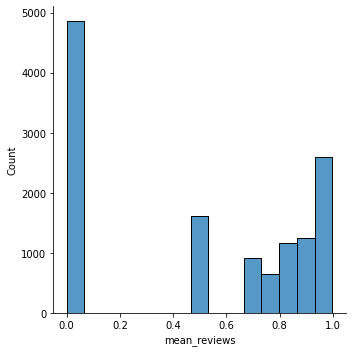

In [32]:
sns.displot(df['mean_reviews'])

#### 2.3.3 Categorical Variables

Refactor variables to categorical, missing values imputing and some other feature engineering.

The 'neighbourhood_cleansed' variable has 151 unique entries. This high variability can bring no info to the model. However, it's public knowledge that city's regions are like clusters, with similarites among their own neighborhoods.

We can group all neighborhoods into Zones, lowering 151 classes to only 4.

In [33]:
df['regioes'] = preprocess.creating_zones(df)

Now that we have the grouped neighborhoods, we can do a quick analysis with the target variable.
One hypotesis is that Zona Sul and Zona Oeste (Barra, Recreio, etc...) have the higher prices than the other regions.

However, as we can see below, The region variable is highly unbalanced. As Zona Sul has over 60% of the observations we can binarize the variable as well, but by judging the statistics below, it might not be a good idea as the Zones have distinct measure positions.

In [34]:
# Zona Sul covers more than 60% rows.
round(df[df['regioes']=='zona_sul'].shape[0]/df.shape[0], 4)

0.6004

As one can see below, the Zona Sul region does not have the highest mean price from the other. However we might not be capturing the "true" statistics from the other regioes due their sample size.

In [35]:
df.groupby('regioes')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
regioes,,,,,,,,
centro,986.0,500.369168,2424.855818,0.0,100.0,160.0,335.0,54000.0
zona_norte,873.0,558.221077,3831.416060,34.0,90.0,180.0,462.0,110918.0
zona_oeste,3353.0,888.205189,2966.075751,35.0,192.0,350.0,800.0,111411.0
zona_sul,7830.0,660.958876,3333.704039,37.0,170.0,281.0,520.0,126233.0


<AxesSubplot:xlabel='regioes', ylabel='log_price'>

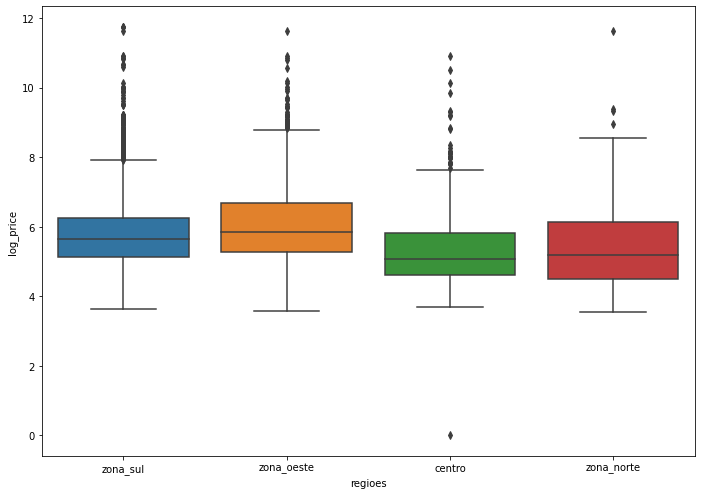

In [36]:
preprocess.plot_configuration()
sns.boxplot(x="regioes", y="log_price", data=df)

Host Response Time' missing values can be filled with a "no_info" category. As we have a lot of missings, the mode inputing could not be the best alternative here (the assumption that 8k missings are from the "within an hour" response can be too heavy here... in this case, missing can infer cases where the host simply does not do the response action at all because the **host_response_rate** is missing for these cases as well).

In [37]:
df['host_response_time'].fillna('no_info', inplace=True)
df['host_response_time'].value_counts(dropna=False)

within an hour        4318
no_info               3988
within a few hours    2031
within a day          1574
a few days or more    1131
Name: host_response_time, dtype: int64

In [38]:
# The variable is mostly constant here.
df['host_response_rate'] = df['host_response_rate'].str.slice(0,-1)
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df['host_response_rate'] = df['host_response_rate'].astype(int)
df[df['host_response_rate']>0]['host_response_rate'].describe()

count    8307.000000
mean       91.123149
std        18.525839
min         1.000000
25%        90.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

Property Type has many categories, so we can refactor it.
The "Entire apartment" entry has almost 50% rows.

In [39]:
df['property_type'].nunique()

75

In [40]:
df['property_type_refactor'] = preprocess.creating_property_type_refactor(df)

In [41]:
# However, its cleary the "others" variable need more refining due its larger std.
df.groupby('property_type_refactor')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type_refactor,,,,,,,,
apartment,7494.0,688.031358,2152.381473,47.0,200.0,349.0,655.0,112205.0
other,2922.0,1063.938398,5689.919047,0.0,145.0,262.5,600.0,126233.0
private_room,2626.0,331.003808,1414.363610,35.0,100.0,160.0,300.0,51000.0


We can create a binary variable indicating if the host lives in RJ. However, as one can see that their distribution are pretty similar the tree model can capture patterns that are not linear.

In [42]:
df['is_host_rj'] = preprocess.creating_host_location(df)

In [43]:
df.groupby('is_host_rj')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
is_host_rj,,,,,,,,
no,5538.0,664.819068,1953.824715,0.0,155.0,300.0,600.00,54550.0
yes,7504.0,726.596882,3900.135262,38.0,160.0,276.0,518.25,126233.0


<AxesSubplot:xlabel='is_host_rj', ylabel='log_price'>

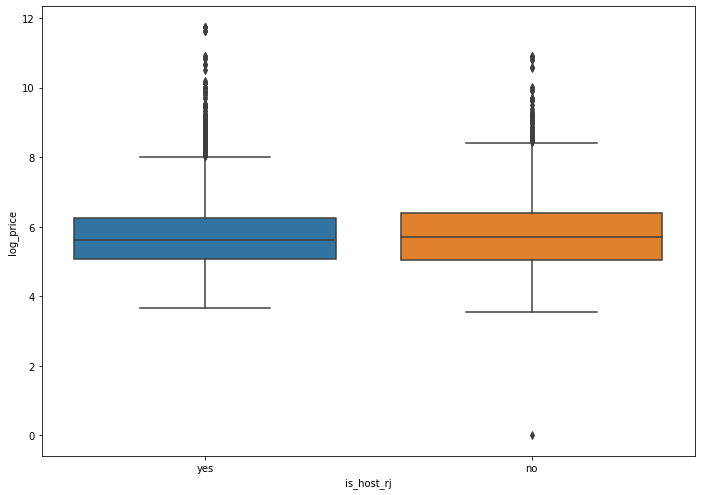

In [44]:
preprocess.plot_configuration()
sns.boxplot(x=df['is_host_rj'], y=df['log_price'])

In [45]:
# Dropping Unused Variables

In [46]:
df.drop(config.to_drop, axis=1, inplace=True)

In [47]:
fillna_dict = {
    'host_response_time': 'no_info',
    'host_is_superhost': df['host_is_superhost'].mode()[0],
    'bedrooms': df['bedrooms'].mode()[0],
    'beds': df['beds'].mode()[0],
    'days_since_host': df['days_since_host'].mode()[0]
}

In [48]:
df.fillna(fillna_dict, inplace=True)